In [226]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [227]:
def create_submission(pred_A, pred_B, pred_C, output_file="submission.csv"):
    """
    Create a Kaggle submission file.

    Parameters:
    - pred_A, pred_B, pred_C: Arrays containing predictions.
    - output_file: Name of the output CSV file.

    Returns:
    - None. Writes the submission to a CSV file.
    """
    
    # Concatenate predictions
    predictions = np.concatenate([pred_A, pred_B, pred_C])

    # Create an id array
    ids = np.arange(0, len(predictions))

    # Create a DataFrame
    df = pd.DataFrame({
        'id': ids,
        'prediction': predictions
    })

    # Save to CSV
    df.to_csv(output_file, index=False)
    print(f"Submission saved to {output_file}")

In [228]:
# Read in the data
data_path = '../../preprocessing/data'
columns_to_remove = ['ceiling_height_agl:m', 'cloud_base_agl:m', 'snow_density:kgm3', 'date_forecast', 'date_calc']


obs_A = pd.read_parquet('../../preprocessing/data/obs_A.parquet')
obs_B = pd.read_parquet('../../preprocessing/data/obs_B.parquet')
obs_C = pd.read_parquet('../../preprocessing/data/obs_C.parquet')
est_A = pd.read_parquet('../../preprocessing/data/est_A.parquet')
est_B = pd.read_parquet('../../preprocessing/data/est_B.parquet')
est_C = pd.read_parquet('../../preprocessing/data/est_C.parquet')
test_A = pd.read_parquet('../../preprocessing/data/test_A.parquet')
test_B = pd.read_parquet('../../preprocessing/data/test_B.parquet')
test_C = pd.read_parquet('../../preprocessing/data/test_C.parquet')
# Columns in A but not in test_A

print(obs_A.columns)
# Columns to drop
columns = [
    'date_forecast',
    'super_cooled_liquid_water:kgm2',
    'air_density_2m:kgm3',
    'snow_water:kgm2',
    'precip_5min:mm',
    'precip_type_5min:idx',
    'rain_water:kgm2',
    'snow_melt_10min:mm',
    'dew_or_rime:idx',
    'snow_depth:cm'
]

# columns += [
#     'direct_rad:W_rate_of_change_of_change',
#     'dew_point_2m:K_rate_of_change',
#     'relative_humidity_1000hPa:p',
#     'effective_cloud_cover:p_rate_of_change_of_change',
#     'total_cloud_cover:p_rate_of_change_of_change',
#     'dew_point_2m:K_rate_of_change_of_change',
#     'diffuse_rad:W_rate_of_change_of_change',
#     't_1000hPa:K_rate_of_change_of_change',
#     'is_day:idx',
#     'is_in_shadow:idx',
#     'prob_rime:p'
# ]

# Drop columns
obs_A = obs_A.drop(columns=columns)
obs_B = obs_B.drop(columns=columns)
obs_C = obs_C.drop(columns=columns)
est_A = est_A.drop(columns=columns)
est_B = est_B.drop(columns=columns)
est_C = est_C.drop(columns=columns)
test_A = test_A.drop(columns=columns)
test_B = test_B.drop(columns=columns)
test_C = test_C.drop(columns=columns)




A = pd.concat([obs_A, est_A])
B = pd.concat([obs_B, est_B])
C = pd.concat([obs_C, est_C])


In [229]:
print(A.columns)

print(test_A.columns)

Index(['pv_measurement', 'diffuse_rad:W', 'direct_rad:W',
       'effective_cloud_cover:p', 'fresh_snow_24h:cm', 'sun_elevation:d',
       'absolute_humidity_2m:gm3', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p',
       ...
       'snow_accumulation', 't_1000hPa:K_rolling_avg_24',
       'msl_pressure:hPa_rolling_avg_24',
       'absolute_humidity_2m:gm3_rolling_avg_24',
       'effective_cloud_cover:p_rolling_avg_6',
       'total_cloud_cover:p_rolling_avg_6', 'sun_elevation:d_rolling_avg_6',
       'clear_sky_rad:W_rolling_avg_6', 'total_radiation_rolling_avg_3',
       'pv_measurement_lag_1'],
      dtype='object', length=104)
Index(['diffuse_rad:W', 'direct_rad:W', 'effective_cloud_cover:p',
       'fresh_snow_24h:cm', 'sun_elevation:d', 'absolute_humidity_2m:gm3',
       'super_cooled_liquid_water:kgm2', 't_1000hPa:K', 'total_cloud_cover:p',
       'air_density_2m:kgm3',
       ...
       'cloud_humidity_product', 'snow_accumulation',
       't_100

In [230]:
X_A = A.drop(columns=['pv_measurement'])
y_A = A['pv_measurement']

X_B = B.drop(columns=['pv_measurement'])
y_B = B['pv_measurement']

X_C = C.drop(columns=['pv_measurement'])
y_C = C['pv_measurement']

X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, y_A, test_size=0.2, shuffle=False)
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B, y_B, test_size=0.2, shuffle=False)
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X_C, y_C, test_size=0.2, shuffle=False)

In [231]:
import xgboost as xgb

# Define the model with the specified parameters
model = xgb.XGBRegressor(
    'colsample_bytree': 0.8, 
    'gamma': 0.8, 
    'learning_rate': 0.008, 
    'max_depth': 10, 
    'min_child_weight': 10, 
    'n_estimators': 550, 
    'reg_alpha': 1, 
    'reg_lambda': 3, 
    'subsample': 0.912,
    'random_state': 0, 
    'booster': 'gbtree'
)

model.fit(X_train_A, y_train_A)



if 'pv_measurement_lag_1' not in test_A.columns:
    test_A.insert(loc=0, column='pv_measurement_lag_1', value=0)  # Change 'loc=0' to match the position in training set


test_A = test_A[X_train_A.columns]

batch_size = 1
print(batch_size)


def predict(model, target, batch_size=1):
    predictions = []
    for i in range(0, len(target), batch_size):
        # Slice the test set to get the next batch
        X_batch = target[i:i+batch_size]
        if i == 0:
            # For the first batch, you might use historical data to fill up the lagged feature
            # For instance, if you have data indicating the 'pv_measurement' for an hour before the test set begins
            target.loc[:batch_size, 'pv_measurement_lag_1'] = 2000
        
        # Check if you need to append the previous predictions to the current batch
        if i > 0:
            # Here, we're assuming that 'pv_measurement' is required as a feature for making predictions
            # so we add the past predictions into the batch
            previous_predictions = predictions[-batch_size:]
            X_batch.loc[:, 'pv_measurement_lag_1'] = previous_predictions


        # Predict the next batch
        y_pred_batch = model.predict(X_batch)
        
        # Store the batch predictions
        predictions.extend(y_pred_batch)
    return predictions
    
predictions = predict(model, test_A, batch_size=batch_size)
y_pred_A_test = predict(model, X_test_A, batch_size=batch_size)




1


Mean Squared Error (MSE): 149457.32290818213
Mean Absolute Error (MAE): 171.63865185215292


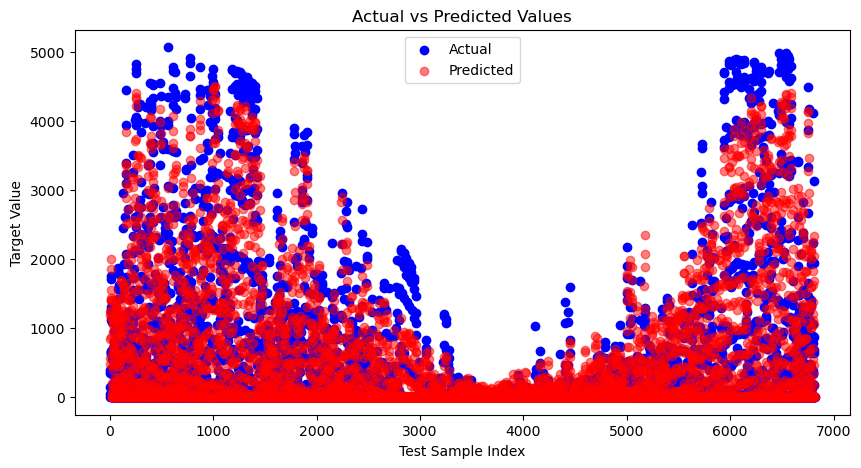

In [232]:

mse = mean_squared_error(y_test_A, y_pred_A_test)
mae = mean_absolute_error(y_test_A, y_pred_A_test)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')


# Plotting the actual vs predicted values
plt.figure(figsize=(10,5))
plt.scatter(range(len(y_test_A)), y_test_A, color='blue', label='Actual')
plt.scatter(range(len(y_pred_A_test)), y_pred_A_test, color='red', label='Predicted', alpha=0.5)
plt.title('Actual vs Predicted Values')
plt.xlabel('Test Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()

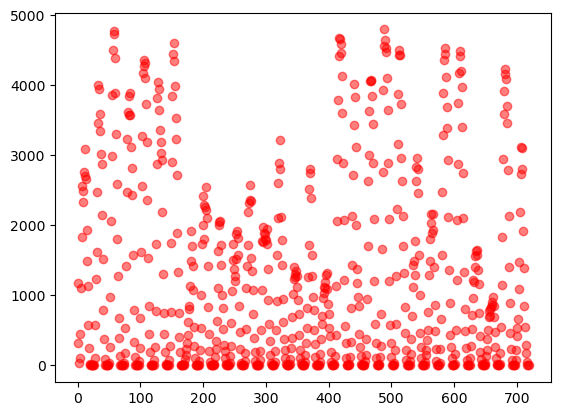

In [233]:
pred_A = predict(model, test_A, batch_size=batch_size)

plt.scatter(range(len(pred_A)), pred_A, color='red', label='Predicted', alpha=0.5)

Mean Squared Error (MSE): 5779.405731135754
Mean Absolute Error (MAE): 29.433840384619277


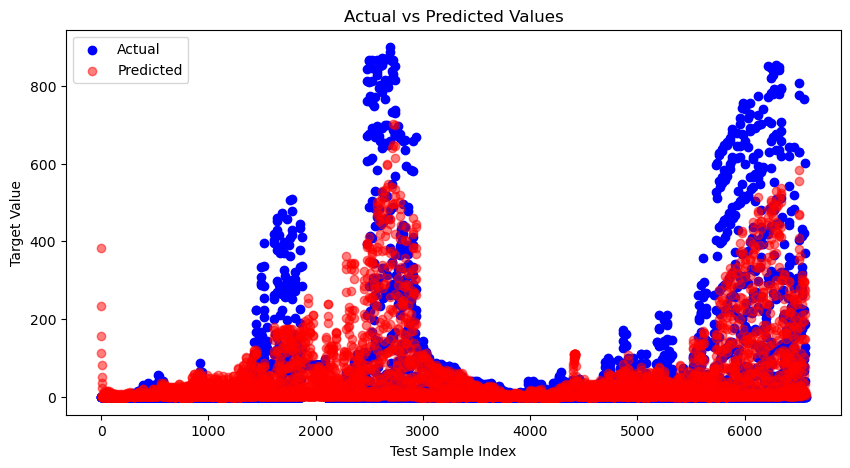

In [234]:
model = xgb.XGBRegressor(
    colsample_bytree=0.5, 
    gamma=0.2,             
    learning_rate=0.007,   
    max_depth=8,           
    min_child_weight=10,   
    n_estimators=500,      
    reg_alpha=3,           
    reg_lambda=3,          
    subsample=0.912        
)


model.fit(X_train_B, y_train_B)
y_pred_B_test = predict(model, X_test_B, batch_size=batch_size)

# Calculate the error metrics
mse = mean_squared_error(y_test_B, y_pred_B_test)
mae = mean_absolute_error(y_test_B, y_pred_B_test)

# Print out the errors
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')

# Plotting the actual vs predicted values
plt.figure(figsize=(10,5))
plt.scatter(range(len(y_test_B)), y_test_B, color='blue', label='Actual')
plt.scatter(range(len(y_pred_B_test)), y_pred_B_test, color='red', label='Predicted', alpha=0.5)
plt.title('Actual vs Predicted Values')
plt.xlabel('Test Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()

# 26.629045123076295

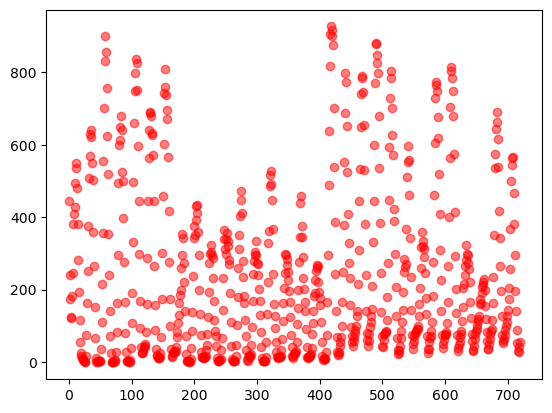

In [235]:
if 'pv_measurement_lag_1' not in test_B.columns:
    test_B.insert(loc=0, column='pv_measurement_lag_1', value=0)  # Change 'loc=0' to match the position in training set


test_B = test_B[X_train_B.columns]

pred_B = predict(model, test_B, batch_size=batch_size)

plt.scatter(range(len(pred_B)), pred_B, color='red', label='Predicted', alpha=0.5)

Mean Squared Error (MSE): 2601.439683912983
Mean Absolute Error (MAE): 20.963267772631035


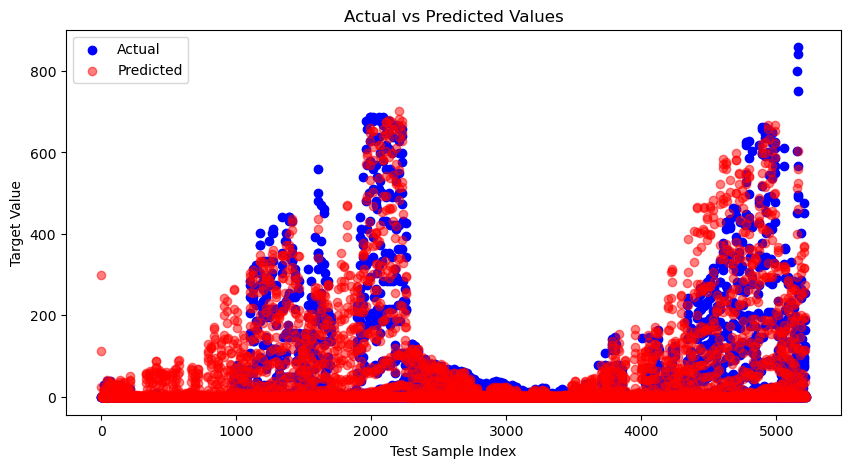

In [236]:
model = xgb.XGBRegressor(
    colsample_bytree=0.8,
    gamma=0.8,
    learning_rate=0.008,
    max_depth=8, 
    min_child_weight=10,
    n_estimators=500,
    reg_alpha=3,  
    reg_lambda=1, 
    subsample=0.912
)


model.fit(X_train_C, y_train_C)
y_pred_C_test = predict(model, X_test_C, batch_size=batch_size)

# Calculate the error metrics
mse = mean_squared_error(y_test_C, y_pred_C_test)
mae = mean_absolute_error(y_test_C, y_pred_C_test)

# Print out the errors
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')

# Plotting the actual vs predicted values
plt.figure(figsize=(10,5))
plt.scatter(range(len(y_test_C)), y_test_C, color='blue', label='Actual')
plt.scatter(range(len(y_pred_C_test)), y_pred_C_test, color='red', label='Predicted', alpha=0.5)
plt.title('Actual vs Predicted Values')
plt.xlabel('Test Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()


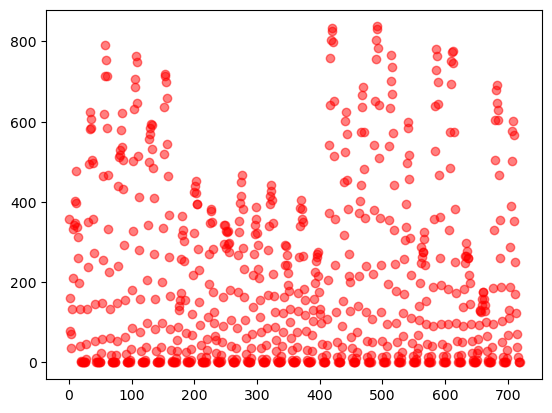

In [237]:
if 'pv_measurement_lag_1' not in test_C.columns:
    test_C.insert(loc=0, column='pv_measurement_lag_1', value=0)  # Change 'loc=0' to match the position in training set


test_C = test_C[X_train_C.columns]

pred_C = predict(model, test_C, batch_size=batch_size)

plt.scatter(range(len(pred_C)), pred_C, color='red', label='Predicted', alpha=0.5)

In [238]:
def create_submission(pred_A, pred_B, pred_C, output_file="submission.csv"):
    """
    Create a Kaggle submission file.

    Parameters:
    - pred_A, pred_B, pred_C: Arrays containing predictions.
    - output_file: Name of the output CSV file.

    Returns:
    - None. Writes the submission to a CSV file.
    """
    
    # Concatenate predictions
    predictions = np.concatenate([pred_A, pred_B, pred_C])

    # Create an id array
    ids = np.arange(0, len(predictions))

    # Create a DataFrame
    df = pd.DataFrame({
        'id': ids,
        'prediction': predictions
    })

    # Save to CSV
    df.to_csv(output_file, index=False)
    print(f"Submission saved to {output_file}")

In [239]:
create_submission(pred_A, pred_B, pred_C, output_file="../../submission.csv")

Submission saved to ../../submission.csv
